## Package Imports

In [4]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import warnings
import scienceplots

## Notebook Setup

In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [6]:
plt.style.use(['notebook', 'grid'])

## Reading data and Preprocessing

**THE DATA IS ALREADY CLEANED SO NOT MUCH IS DONE HERE**

In [7]:
df_true = pd.read_csv('./data/True.csv')
df_fake = pd.read_csv('./data/Fake.csv')

In [8]:
df_true['isFake'] = 0
df_fake['isFake'] = 1

In [9]:
combined_df = pd.concat([df_true, df_fake], axis=0)
combined_and_shuffeld_dF = combined_df.sample(frac=1).reset_index(drop=True)

In [10]:
df = combined_and_shuffeld_dF

In [11]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Exploratory data analysis

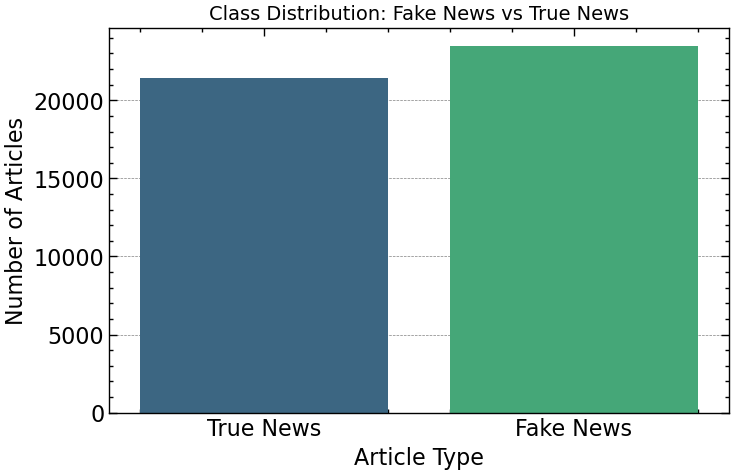

In [29]:
class_distribution = df['isFake'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title('Class Distribution: Fake News vs True News', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['True News', 'Fake News'])
plt.ylabel('Number of Articles')
plt.xlabel('Article Type')
plt.show()

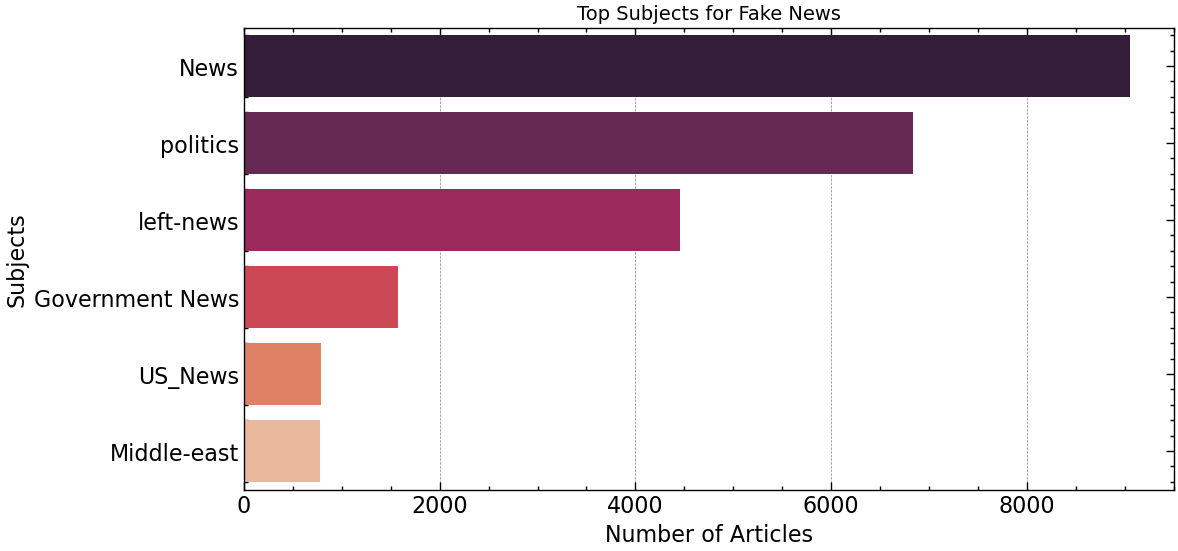

In [30]:
subject_distribution = df.groupby(['isFake', 'subject']).size().reset_index(name='count')
fake_subjects = subject_distribution[subject_distribution['isFake'] == 1].sort_values(by='count', ascending=False)
true_subjects = subject_distribution[subject_distribution['isFake'] == 0].sort_values(by='count', ascending=False)


plt.figure(figsize=(12, 6))
sns.barplot(y=fake_subjects['subject'], x=fake_subjects['count'], palette="rocket")
plt.title('Top Subjects for Fake News', fontsize=14)
plt.xlabel('Number of Articles')
plt.ylabel('Subjects')
plt.show()


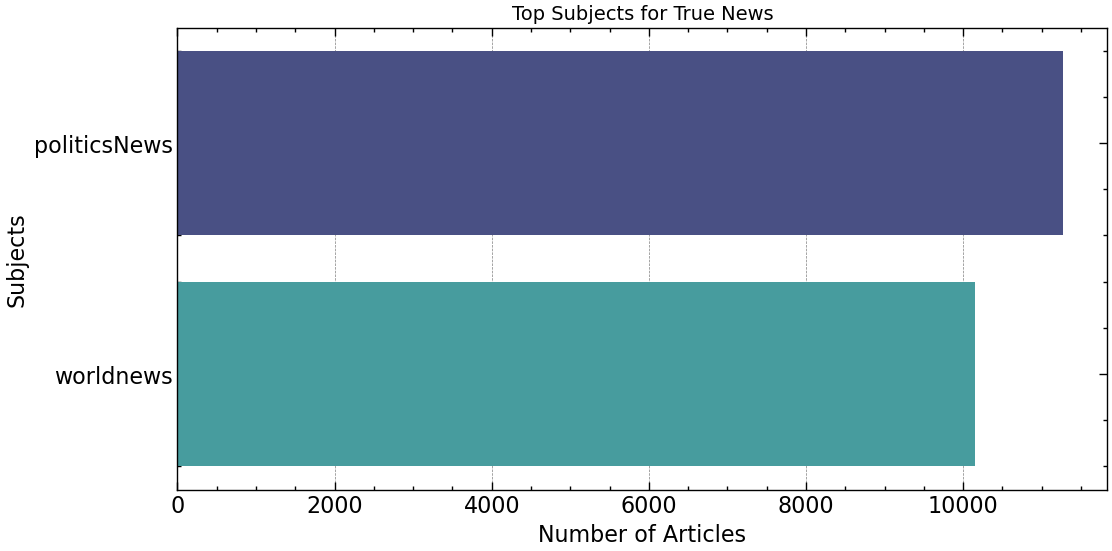

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(y=true_subjects['subject'], x=true_subjects['count'], palette="mako")
plt.title('Top Subjects for True News', fontsize=14)
plt.xlabel('Number of Articles')
plt.ylabel('Subjects')
plt.show()

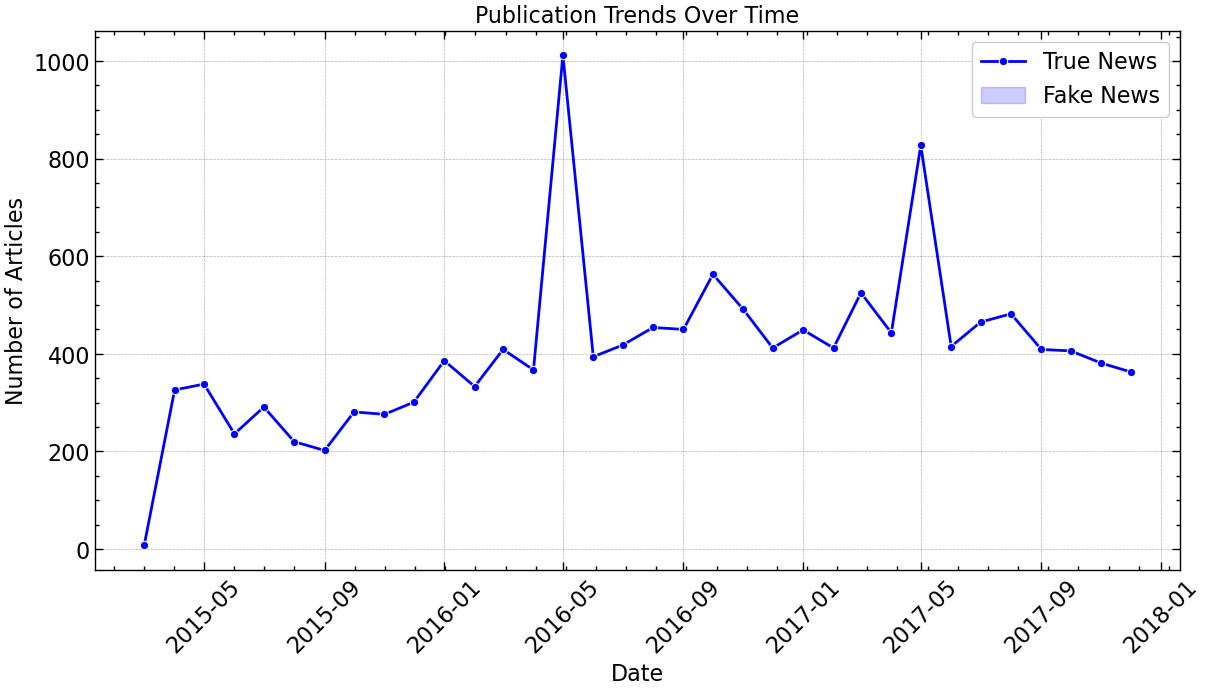

In [32]:
trend_data = df.groupby([df['date'].dt.to_period('M'), 'isFake']).size().reset_index(name='count')
trend_data['date'] = trend_data['date'].dt.to_timestamp()

plt.figure(figsize=(14, 7))
sns.lineplot(data=trend_data, x='date', y='count', hue='isFake', palette=["blue", "red"], marker="o")
plt.title('Publication Trends Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend(labels=["True News", "Fake News"])
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

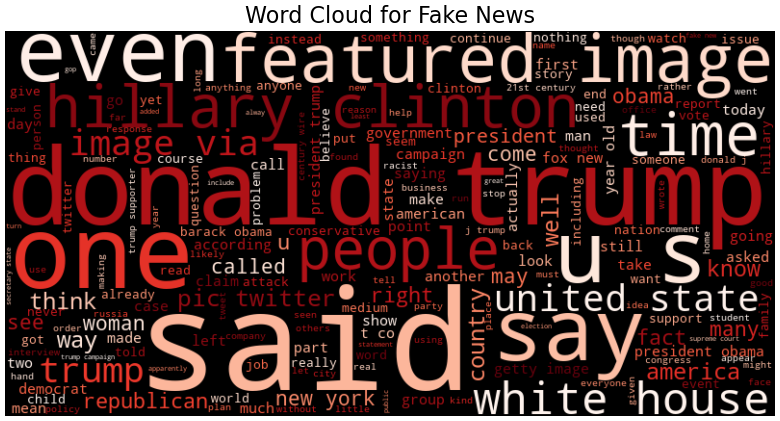

In [33]:
fake_text = ' '.join(df[df['isFake'] == 1]['text'].dropna())
true_text = ' '.join(df[df['isFake'] == 0]['text'].dropna())


fake_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(fake_text)
plt.figure(figsize=(10, 5))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News', fontsize=16)
plt.show()

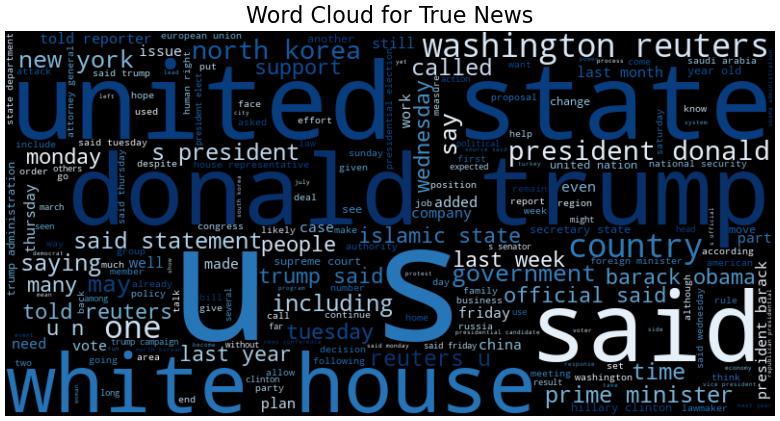

In [34]:
true_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Blues').generate(true_text)
plt.figure(figsize=(10, 5))
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for True News', fontsize=16)
plt.show()


## Tokenization & Vectorization

In [12]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    return ' '.join(tokens)

In [13]:
df['text'] = df['text'].apply(preprocess_text)
df['title'] = df['title'].apply(preprocess_text)

In [44]:
text_vectorizer = TfidfVectorizer(max_features=5000)
title_vectorizer = TfidfVectorizer(max_features=5000)

vectorized_text = text_vectorizer.fit_transform(df['text'])
vectorized_title = title_vectorizer.fit_transform(df['title'])

X = hstack([vectorized_text, vectorized_title])

y = df['isFake']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42)


## Model Building 

In [16]:
gb_clf = GradientBoostingClassifier()
rf_clf = RandomForestClassifier()
ab_clf = AdaBoostClassifier()

In [17]:
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [18]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
ab_clf.fit(X_train, y_train)

AdaBoostClassifier()

## Model Evaluation

In [28]:
model_names = [
    'Gradient Boosting Classifier',
    'Random Forest Classifier',
    'Ada Boost Classifier',
]

models = [gb_clf, rf_clf, ab_clf]

In [31]:
print('-'*55)

for model_name, model in zip(model_names, models):
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    print(f'{model_name} Training Accuracy =  %{round(train_accuracy * 100, 2)}')
    print(f'{model_name} Testing Accuracy =  %{round(test_accuracy * 100, 2)}')
    print('-'*55)

-------------------------------------------------------
Gradient Boosting Classifier Training Accuracy =  %99.81
Gradient Boosting Classifier Testing Accuracy =  %99.76
-------------------------------------------------------
Random Forest Classifier Training Accuracy =  %100.0
Random Forest Classifier Testing Accuracy =  %99.85
-------------------------------------------------------
Ada Boost Classifier Training Accuracy =  %99.87
Ada Boost Classifier Testing Accuracy =  %99.76
-------------------------------------------------------


Gradient Boosting Classifier Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5271
           1       1.00      1.00      1.00      5954

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



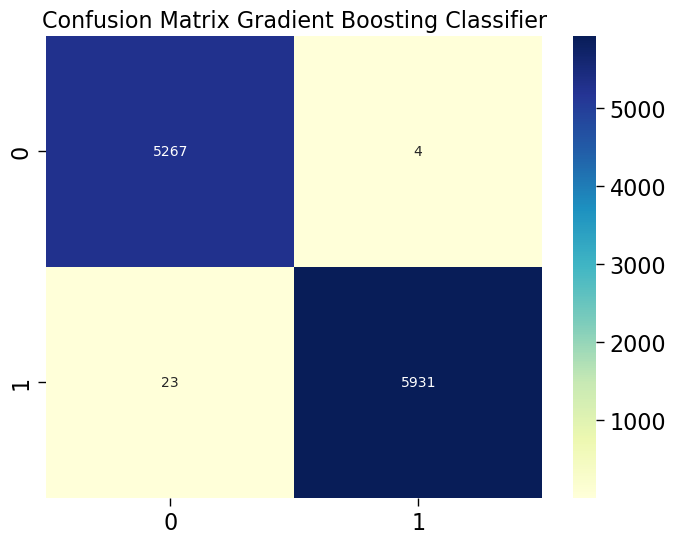

In [41]:
print(f'{model_names[0]} Classification Report:\n')
y_pred = models[0].predict(X_test)
class_rep = classification_report(y_test, y_pred)
print(class_rep)

sns.heatmap(confusion_matrix(y_test, y_pred), fmt='d', annot=True, cmap='YlGnBu')
plt.title(f'Confusion Matrix {model_names[0]}')
plt.show()

Ada Boost Classifier Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5271
           1       1.00      1.00      1.00      5954

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



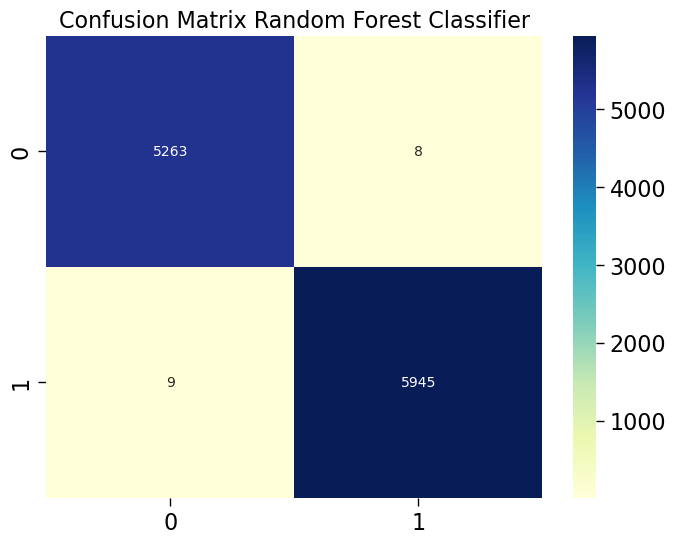

In [42]:
print(f'{model_names[2]} Classification Report:\n')
y_pred = models[1].predict(X_test)
class_rep = classification_report(y_test, y_pred)
print(class_rep)

sns.heatmap(confusion_matrix(y_test, y_pred), fmt='d', annot=True, cmap='YlGnBu')
plt.title(f'Confusion Matrix {model_names[1]}')
plt.show()

Ada Boost Classifier Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5271
           1       1.00      1.00      1.00      5954

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



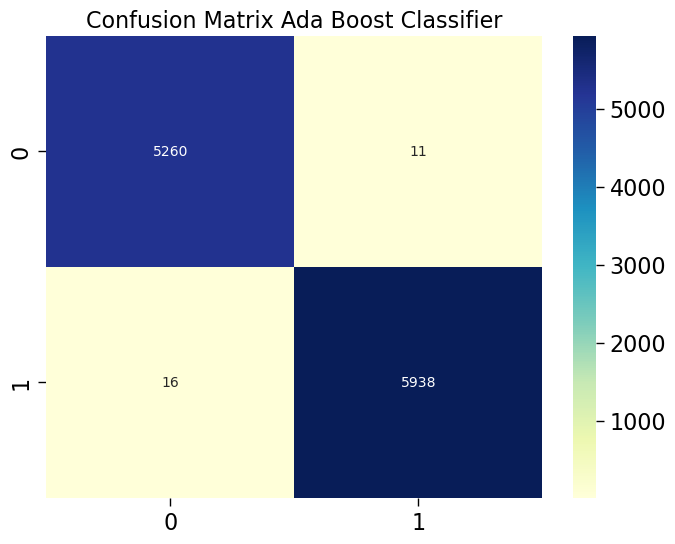

In [43]:
print(f'{model_names[2]} Classification Report:\n')
y_pred = models[2].predict(X_test)
class_rep = classification_report(y_test, y_pred)
print(class_rep)

sns.heatmap(confusion_matrix(y_test, y_pred), fmt='d', annot=True, cmap='YlGnBu')
plt.title(f'Confusion Matrix {model_names[2]}')
plt.show()

## Testing The ML Models on Input Data

In [97]:
def process_input(title, text, text_vectorizer, title_vectorizer):
    title = preprocess_text(title)
    text = preprocess_text(text)

    vectorized_text = text_vectorizer.transform([text])  
    vectorized_title = title_vectorizer.transform([title]) 
    X_test = hstack([vectorized_text, vectorized_title])

    return X_test

In [99]:
test_df = pd.read_csv('./data/tst_npt.csv')
title = test_df['title'][0]
text = test_df['text'][0]

for model_name, model in zip(model_names, models):
    predicton = model.predict(process_input(title, text, text_vectorizer, title_vectorizer)) 
    print(f'{model_name} Prediction: {predicton[0] == 0 if predicton[0] == 1 else "Fake News"}')

Gradient Boosting Classifier Prediction: Fake News
Random Forest Classifier Prediction: Fake News
Ada Boost Classifier Prediction: Fake News
